In [ ]:
##https://wonhwa.tistory.com/52
##[python] 네이버 뉴스 크롤러(날짜,링크,제목, 본문)

In [20]:
# 1. 라이브러리 불러오기
#크롤링시 필요한 라이브러리 불러오기

from bs4 import BeautifulSoup
import requests
import re
import datetime
from tqdm import tqdm
import sys

In [21]:
# 2. 크롤링 시 필요한 함수 만들기
# 페이지 url 형식에 맞게 바꾸어 주는 함수 만들기
  #입력된 수를 1, 11, 21, 31 ...만들어 주는 함수
def makePgNum(num):
    if num == 1:
        return num
    elif num == 0:
        return num+1
    else:
        return num+9*(num-1)

# 크롤링할 url 생성하는 함수 만들기(검색어, 크롤링 시작 페이지, 크롤링 종료 페이지)

def makeUrl(search, start_pg, end_pg):
    if start_pg == end_pg:
        start_page = makePgNum(start_pg)
        url = "https://search.naver.com/search.naver?where=news&sm=tab_pge&query=" + search + "&start=" + str(start_page)
        print("생성url: ", url)
        return url
    else:
        urls = []
        for i in range(start_pg, end_pg + 1):
            page = makePgNum(i)
            url = "https://search.naver.com/search.naver?where=news&sm=tab_pge&query=" + search + "&start=" + str(page)
            # url = "https://search.naver.com/search.naver?where=news&sm=tab_pge&query=" + search + "&sort=0&photo=0&field=0&pd=3&ds=2023.08.01&de=2023.08.02&cluster_rank=62&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso=so:r,p:all,a:all&start=" + str(page)
            urls.append(url)
        print("생성url: ", urls)
        return urls   

# html에서 원하는 속성 추출하는 함수 만들기 (기사, 추출하려는 속성값)
def news_attrs_crawler(articles,attrs):
    attrs_content=[]
    for i in articles:
        attrs_content.append(i.attrs[attrs])
    return attrs_content

# ConnectionError방지
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/98.0.4758.102"}

#html생성해서 기사크롤링하는 함수 만들기(url): 링크를 반환
def articles_crawler(url):
    #html 불러오기
    original_html = requests.get(i,headers=headers)
    html = BeautifulSoup(original_html.text, "html.parser")

    url_naver = html.select("div.group_news > ul.list_news > li div.news_area > div.news_info > div.info_group > a.info")
    url = news_attrs_crawler(url_naver,'href')
    return url

In [22]:
#3. 크롤링할 네이버 뉴스 URL 추출하기
#####뉴스크롤링 시작#####

#검색어 입력
search = input("검색할 키워드를 입력해주세요:")
#검색 시작할 페이지 입력
page = int(input("\n크롤링할 시작 페이지를 입력해주세요. ex)1(숫자만입력):")) # ex)1 =1페이지,2=2페이지...
print("\n크롤링할 시작 페이지: ",page,"페이지")   
#검색 종료할 페이지 입력
page2 = int(input("\n크롤링할 종료 페이지를 입력해주세요. ex)1(숫자만입력):")) # ex)1 =1페이지,2=2페이지...
print("\n크롤링할 종료 페이지: ",page2,"페이지")   


# naver url 생성
url = makeUrl(search,page,page2)

#뉴스 크롤러 실행
news_titles = []
news_url =[]
news_contents =[]
news_dates = []
for i in url:
    url = articles_crawler(url)
    news_url.append(url)


#제목, 링크, 내용 1차원 리스트로 꺼내는 함수 생성
def makeList(newlist, content):
    for i in content:
        for j in i:
            newlist.append(j)
    return newlist

    
#제목, 링크, 내용 담을 리스트 생성
news_url_1 = []

#1차원 리스트로 만들기(내용 제외)
makeList(news_url_1,news_url)

#NAVER 뉴스만 남기기
final_urls = []
for i in tqdm(range(len(news_url_1))):
    if "news.naver.com" in news_url_1[i]:
        final_urls.append(news_url_1[i])
    else:
        pass


크롤링할 시작 페이지:  1 페이지

크롤링할 종료 페이지:  5 페이지
생성url:  ['https://search.naver.com/search.naver?where=news&sm=tab_pge&query=초전도체&start=1', 'https://search.naver.com/search.naver?where=news&sm=tab_pge&query=초전도체&start=11', 'https://search.naver.com/search.naver?where=news&sm=tab_pge&query=초전도체&start=21', 'https://search.naver.com/search.naver?where=news&sm=tab_pge&query=초전도체&start=31', 'https://search.naver.com/search.naver?where=news&sm=tab_pge&query=초전도체&start=41']


100%|██████████| 100/100 [00:00<00:00, 101828.21it/s]


In [23]:
# 4.뉴스 본문 및 날짜 크롤링하기
# 뉴스 내용 크롤링

for i in tqdm(final_urls):
    #각 기사 html get하기
    news = requests.get(i,headers=headers)
    news_html = BeautifulSoup(news.text,"html.parser")
    # 뉴스 제목 가져오기
    title = news_html.select_one("#ct > div.media_end_head.go_trans > div.media_end_head_title > h2")
    if title == None:
        title = news_html.select_one("#content > div.end_ct > div > h2")
    
    # 뉴스 본문 가져오기
    content = news_html.select("div#dic_area")
    if content == []:
        content = news_html.select("#articeBody")
    
    ###수정
    if content == []:
        content = news_html.select("#dic_area")
    if content == []:
        content = news_html.select("#newsEndContents")
    
        
    # 기사 텍스트만 가져오기
    # list합치기
    content = ''.join(str(content))

    # html태그제거 및 텍스트 다듬기
    pattern1 = '<[^>]*>'
    title = re.sub(pattern=pattern1, repl='', string=str(title))
    content = re.sub(pattern=pattern1, repl='', string=content)
    pattern2 = """[\n\n\n\n\n// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_removeCallback() {}"""
    content = content.replace(pattern2, '')

    news_titles.append(title)
    news_contents.append(content)

    try:
        html_date = news_html.select_one("div#ct> div.media_end_head.go_trans > div.media_end_head_info.nv_notrans > div.media_end_head_info_datestamp > div > span")
        news_date = html_date.attrs['data-date-time']
    except AttributeError:
        news_date = news_html.select_one("#content > div.end_ct > div > div.article_info > span > em")
        news_date = re.sub(pattern=pattern1,repl='',string=str(news_date))
    # 날짜 가져오기
    news_dates.append(news_date)

print("검색된 기사 갯수: 총 ",(page2+1-page)*10,'개')
print("\n[뉴스 제목]")
print(news_titles)
print("\n[뉴스 링크]")
print(final_urls)
print("\n[뉴스 내용]")
print(news_contents)

print('news_title: ',len(news_titles))
print('news_url: ',len(final_urls))
print('news_contents: ',len(news_contents))
print('news_dates: ',len(news_dates))

100%|██████████| 50/50 [01:07<00:00,  1.36s/it]

검색된 기사 갯수: 총  50 개

[뉴스 제목]
["'LK-99' 해프닝으로 끝나나…'초전도체 아니다' 해외검증 잇따라", "20분만에 '개미지옥'…초전도체주 급락 배후는 '알고리즘'?", '"초전도체 아니다" 美 연구소 발표에 테마주 \'와르르\' 급락(종합)', '"게임 끝났다" 주가 폭락에도…일부 초전도체 테마주 반등', "'초전도체' 검증 실패에 롤코타는 주가…대주주만 웃었다", '초전도체 관련주 혼조세…서남·덕성 급락 출발', '"LK-99, 초전도체 아니다"', '초전도체 테마주 과열에…금감원장 “리딩방 풍문 특별단속”', '“LK-99, 초전도체 아냐” 美 발표에도…일부 테마주 상승', '"게임 끝났다"…해외 초전도체 부정에 관련주 \'우수수\'', '초전도체 테마주 과열에…금감원장 “리딩방 풍문 특별단속”', '美 연구소 "LK-99, 초전도체 아니다" 발표에 관련주 \'주르륵\'', "금감원장 경고에 급락한 초전도체주…개미들 '와글와글'", "천당·지옥 오간 초전도체주…검증 논란 속 '급락'(종합)", '상온 초전도체 논란 속 신성델타테크, 이틀 연속 상한가', '“LK-99, 초전도체 아냐” 美 발표에도…일부 테마주 상승', '美 연구진 "LK-99, 초전도체 아냐…저항 큰 저질 재료"', '"게임 끝났다"…해외 초전도체 부정에 관련주 \'우수수\'', '코스닥, 되살아난 2차전지에 900 회복…초전도체주 급락', '“우리는 초전도체 회사 아닙니다” 공지 올렸던 회사의 속사정', "[특징주] 초전도체 관련주, 'LK-99' 초전도체 아니다 결론에... 일제히 급락", '[특징주] 초전도체주, 하루 만에 냉탕서 온탕으로…"변동성 주의"', "배터리·초전도체 혼란 속 로봇 '상승세'…테마주 대안 될까", "'제2의 에코프로' 꿈꿨는데...초전도체 테마주 와르르", "[어제장 오늘장] 초전도체-2차전지 '수급 핑퐁'…혼조 속 살아남은 업종은?", '"논문대로 따라해봤는데" 韓 초전도체 잇단 검증실패…퀀텀 "한달 내 판가름"', '美 연구진 "게임

In [24]:
# 5. 데이터 프레임 만들고 CSV파일로 저장하기
###데이터 프레임으로 만들기###
import pandas as pd

#데이터 프레임 만들기
news_df = pd.DataFrame({'date':news_dates,'title':news_titles,'link':final_urls,'content':news_contents})
news_df

#중복 행 지우기
news_df = news_df.drop_duplicates(keep='first',ignore_index=True)
print("중복 제거 후 행 개수: ",len(news_df))

#데이터 프레임 저장
now = datetime.datetime.now() 
news_df.to_csv('{}_{}.csv'.format(search,now.strftime('%Y%m%d_%H시%M분%S초')),encoding='utf-8-sig',index=False)

중복 제거 후 행 개수:  47


In [25]:
df = news_df
df

,date,title,link,content
0,2023-08-09 10:13:26,'LK-99' 해프닝으로 끝나나…'초전도체 아니다' 해외검증 잇따라,https://n.news.naver.com/mnews/article/001/001...,"[\n美 프린스턴대 등 국제연구진 ""초전도체 아닌 강자성체 가능성 커""(서울=연합뉴..."
1,2023-08-09 09:41:15,20분만에 '개미지옥'…초전도체주 급락 배후는 '알고리즘'?,https://n.news.naver.com/mnews/article/008/000...,[\n\n\n\n\n/사진=유안타증권.지난 8일 초전도체 관련 종목의 주가 하락과 ...
2,2023-08-08 16:09:44,"""초전도체 아니다"" 美 연구소 발표에 테마주 '와르르' 급락(종합)",https://n.news.naver.com/mnews/article/001/001...,[\n\n\n\n\n'물리학의 성배' 해외서도 뜨거운 초전도체(서울=연합뉴스) 꿈의...
3,2023-08-09 09:43:05,"""게임 끝났다"" 주가 폭락에도…일부 초전도체 테마주 반등",https://n.news.naver.com/mnews/article/015/000...,"[\nLS전선아시아, 신성델타테크 '강세'""초전도체 테마주 변동성 주의해야""\n\n..."
4,2023-08-09 02:01:01,'초전도체' 검증 실패에 롤코타는 주가…대주주만 웃었다,https://n.news.naver.com/mnews/article/053/000...,[\n\n\n\n\n8일 서울 중구 하나은행 딜링룸에서 직원들이 업무를 보고 있다....
5,2023-08-09 09:29:03,초전도체 관련주 혼조세…서남·덕성 급락 출발,https://n.news.naver.com/mnews/article/003/001...,"[\n신성델타테크, 2% 상승 중\n\n\n\n퀀텀에너지연구소 및 한양대 연구진이 ..."
6,2023-08-08 19:46:06,"""LK-99, 초전도체 아니다""",https://n.news.naver.com/mnews/article/029/000...,[\n\t\t\t국내 연구진이 개발했다고 주장한 상온 초전도체 'LK-99'에 대한...
7,2023-08-08 14:37:06,초전도체 테마주 과열에…금감원장 “리딩방 풍문 특별단속”,https://n.news.naver.com/mnews/article/028/000...,[\n\n\n\n\n금융감독원 전경. 신소영 기자금융당국이 테마주와 관련된 거짓 소...
8,2023-08-09 10:09:01,"“LK-99, 초전도체 아냐” 美 발표에도…일부 테마주 상승",https://n.news.naver.com/mnews/article/009/000...,[\n\n\n\n\n 국내 연구진이 개발했다고 주장하는 상온·상압 초전도체 LK-9...
9,2023-08-08 16:17:02,"""게임 끝났다""…해외 초전도체 부정에 관련주 '우수수'",https://n.news.naver.com/mnews/article/277/000...,[\n\t\t\t초전도체 관련주들이 무더기로 급락했다. 미국과 중국 등 해외에서 L...


In [26]:
df['content'] = df['content'].str.replace('[^가-힣]', ' ', regex = True)
df['content']

0         프린스턴대 등 국제연구진  초전도체 아닌 강자성체 가능성 커  서울 연합뉴스...
1            사진 유안타증권 지난  일 초전도체 관련 종목의 주가 하락과 관련해 알...
2            물리학의 성배  해외서도 뜨거운 초전도체 서울 연합뉴스  꿈의 물질  ...
3         전선아시아  신성델타테크  강세  초전도체 테마주 변동성 주의해야     사...
4            일 서울 중구 하나은행 딜링룸에서 직원들이 업무를 보고 있다      ...
5       신성델타테크     상승 중    퀀텀에너지연구소 및 한양대 연구진이 공개한 상...
6          국내 연구진이 개발했다고 주장한 상온 초전도체        에 대한 검증에...
7           금융감독원 전경  신소영 기자금융당국이 테마주와 관련된 거짓 소문을 퍼뜨...
8            국내 연구진이 개발했다고 주장하는 상온 상압 초전도체         사...
9          초전도체 관련주들이 무더기로 급락했다  미국과 중국 등 해외에서      ...
10          사진 연합뉴스미국의 한 연구소가 상온 초전도체        에 대해 초전...
11      열흘간 관련주    억 순매수 일부 손실 진입개미들  주주보호 위해 거래정지 후...
12       상한가  신성델타테크  하락 전환이복현 금감원장  테마주 과열 우려      ...
13      관련 테마주 일제히 강세     서울 뉴시스  퀀텀에너지연구소와 한양대 연구진이...
14          국내 민간기업 퀀텀에너지연구소 등 연구팀이 개발했다고 밝힌 상온 초전도체...
15      전거래일 대비       오른        거래중하락 출발 후 반등 외인 매수세...
16      대정화금  최대주주 송기섭 회장   세로 고령주가 오르면 증여세 부담 커질 우려...
17           서울 뉴시스  퀀텀에너지연구소와 한양대 연구진이 공개한 상온 초

In [27]:
import konlpy
kkma = konlpy.tag.Kkma() #형태소 분석기 꼬꼬마(Kkma)

nouns = df['content'].apply(kkma.nouns)
nouns

0     [프린스, 프린스턴대, 턴, 대, 등, 국제, 국제연구진, 연구진, 전도체, 강자,...
1     [사진, 유, 유안타증권, 안타, 증권, 일, 전도체, 관련, 종목, 주가, 하락,...
2     [물리학, 성배, 해외, 전도체, 서울, 연합, 연합뉴스, 뉴스, 꿈, 물질, 상온...
3     [전선, 전선아시아, 아시아, 신성, 신성델타테크, 델타, 테크, 강세, 전도체, ...
4     [일, 서울, 중구, 하나, 하나은행, 은행, 링, 링룸, 룸, 직원, 업무, 뉴,...
5     [신성, 신성델타테크, 델타, 테크, 상승, 중, 퀀, 퀀텀에너지연구소, 텀, 에너...
6     [국내, 연구진, 개발, 주장, 상온, 전도체, 검증, 부정적, 기류, 해외, 연구...
7     [금융, 금융감독원, 감독원, 전경, 신, 영, 기자, 기자금융당국, 당국, 테마,...
8     [국내, 연구진, 개발, 주장, 상온, 상압, 전도체, 사진, 출처, 유, 유튜브,...
9     [전도체, 관련주, 무더기, 급락, 미국, 중국, 등, 해외, 특성, 부정적, 의견...
10    [사진, 연합, 연합뉴스미국, 뉴스, 미국, 연구소, 상온, 전도체, 결론, 소식,...
11    [열흘, 열흘간, 간, 관련주, 억, 순, 순매수, 매수, 일부, 손실, 진입, 진...
12    [상한가, 신성, 신성델타테크, 델타, 테크, 하락, 전환, 복, 금감, 금감원장,...
13    [관련, 테마, 강세, 서울, 뉴, 뉴시스, 시스, 퀀, 퀀텀에너지연구소, 텀, 에...
14    [국내, 민간, 민간기업, 기업, 퀀, 퀀텀에너지연구소, 텀, 에너지, 연구소, 등...
15    [전, 전거래일, 거래, 일, 대비, 거래중하락, 중, 하락, 출발, 후, 반등, ...
16    [대정, 금, 최대, 최대주주, 주주, 송, 송기섭, 기섭, 회장, 세로, 고령, ...
17    [서울, 뉴, 뉴시스, 시스, 퀀, 퀀텀에너지연구소, 텀, 에너지, 연구소,

In [42]:
## explode 메서드는 리스트형태의 값을 여러 행으로 전개하는 메서드 입니다.
nouns = nouns.explode()
nouns

0       프린스
0     프린스턴대
0         턴
0         대
0         등
      ...  
46        달
46       내용
46       종합
46       발표
46       자리
Name: content, Length: 8356, dtype: object

In [44]:
df_word = pd.DataFrame({'word' : nouns})
df_word['count'] = df_word['word'].str.len()
df_word = df_word.query('count >= 2')
df_word

,word,count
0,프린스,3
0,프린스턴대,5
0,국제,2
0,국제연구진,5
0,연구진,3
...,...,...
46,보도,2
46,내용,2
46,종합,2
46,발표,2


In [45]:
## 여기서 빈도수 체크하면 된다.
df_word = df_word.groupby('word', as_index = False).count().sort_values('count', ascending = False)
df_word

,word,count
1585,전도체,47
903,상온,40
61,거래,33
1960,테마,33
200,관련,31
...,...,...
1206,연관,1
1205,연고점,1
1204,연고,1
1203,연결고리,1


In [46]:
# 키워드같은 불필요한 단어 제거
df_word = df_word.iloc[2:, :]
df_word.head(5)

,word,count
61,거래,33
1960,테마,33
200,관련,31
1714,주가,31
661,물질,31


In [47]:
dic_word = df_word.set_index('word').to_dict()['count']
dic_word

{'거래': 33,
 '테마': 33,
 '관련': 31,
 '주가': 31,
 '물질': 31,
 '연구소': 31,
 '에너지': 30,
 '연구진': 30,
 '개발': 29,
 '덕성': 29,
 '주장': 28,
 '미국': 28,
 '종목': 28,
 '관련주': 27,
 '서남': 27,
 '뉴스': 26,
 '국내': 26,
 '전날': 26,
 '한국': 26,
 '테크': 26,
 '급락': 26,
 '신성': 25,
 '대비': 25,
 '델타': 25,
 '이날': 25,
 '투자': 25,
 '신성델타테크': 25,
 '하락': 24,
 '초전도': 24,
 '상압': 24,
 '논문': 24,
 '모비스': 23,
 '퀀텀에너지연구소': 23,
 '센터': 23,
 '서울': 23,
 '랜드': 23,
 '파워': 23,
 '발표': 22,
 '거래일': 22,
 '직스': 22,
 '시장': 22,
 '연구': 22,
 '증권': 22,
 '기자': 21,
 '급등': 21,
 '저온': 21,
 '응집': 21,
 '최근': 21,
 '게임': 21,
 '공개': 21,
 '지난달': 20,
 '이론': 20,
 '오전': 20,
 '오후': 19,
 '상승': 19,
 '저항': 19,
 '서원': 19,
 '우리': 18,
 '주식': 18,
 '기관': 17,
 '검증': 17,
 '사이트': 17,
 '테마주': 17,
 '이브': 16,
 '투자자': 16,
 '강세': 16,
 '일부': 16,
 '상한가': 16,
 '연구원': 16,
 '대창': 16,
 '사진': 16,
 '현재': 16,
 '이후': 16,
 '기업': 16,
 '기준': 15,
 '사전': 15,
 '전기': 15,
 '분석': 15,
 '물리': 15,
 '금융': 15,
 '마감': 14,
 '가운데': 14,
 '제공': 14,
 '확인': 14,
 '주의': 14,
 '코스닥': 14,
 '상승세': 14,
 '현상': 14,
 '결과':

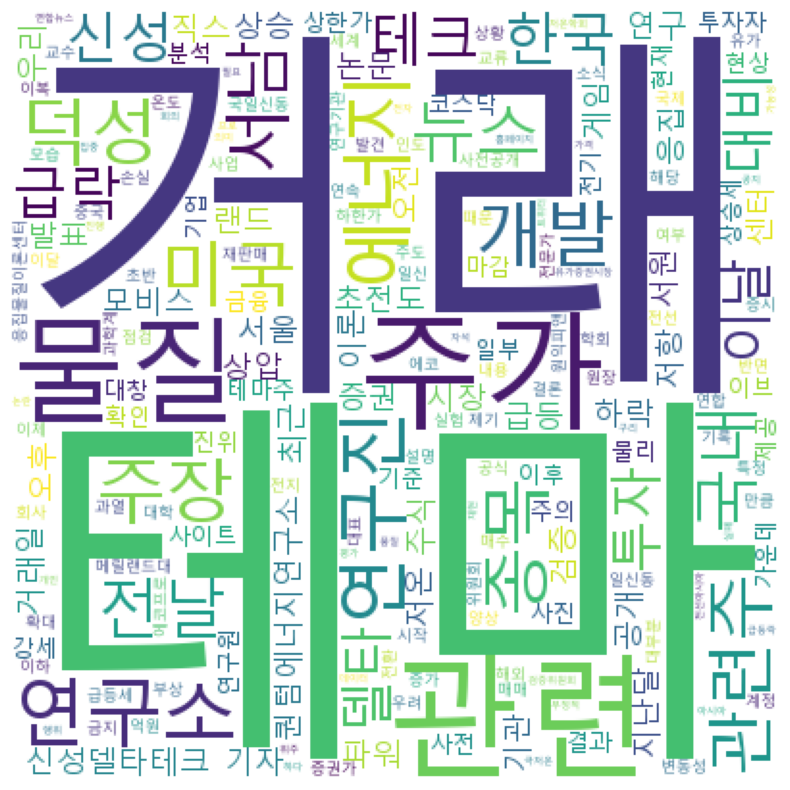

In [48]:
from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리

wc = WordCloud(random_state = 123, font_path = 'malgun', width = 400,
               height = 400, background_color = 'white')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기
plt.savefig('워드클라우드') # 파일 저장
plt.show()

In [55]:
## 빈도수 그래프
from collections import Counter
new_nouns = []
# 두글자 이상 단어만 구별
word = [w for w in nouns if len(w) > 1]
new_nouns.extend(word)

count = Counter(new_nouns)

# noun_list = count.most_common(100)
# for v in noun_list:
#     print(v)

In [63]:
wordInfo = dict()
for tags, counts in count.most_common(50):
    # print(tags, counts)
    if (len(str(tags)) > 1):
        wordInfo[tags] = counts
        print ("%s : %d" % (tags, counts))

전도체 : 47
상온 : 40
테마 : 33
거래 : 33
연구소 : 31
물질 : 31
관련 : 31
주가 : 31
연구진 : 30
에너지 : 30
개발 : 29
덕성 : 29
주장 : 28
미국 : 28
종목 : 28
관련주 : 27
서남 : 27
뉴스 : 26
한국 : 26
국내 : 26
급락 : 26
전날 : 26
테크 : 26
투자 : 25
신성 : 25
신성델타테크 : 25
델타 : 25
이날 : 25
대비 : 25
상압 : 24
논문 : 24
초전도 : 24
하락 : 24
서울 : 23
퀀텀에너지연구소 : 23
센터 : 23
랜드 : 23
모비스 : 23
파워 : 23
연구 : 22
발표 : 22
증권 : 22
거래일 : 22
시장 : 22
직스 : 22
기자 : 21
저온 : 21
응집 : 21
게임 : 21
공개 : 21


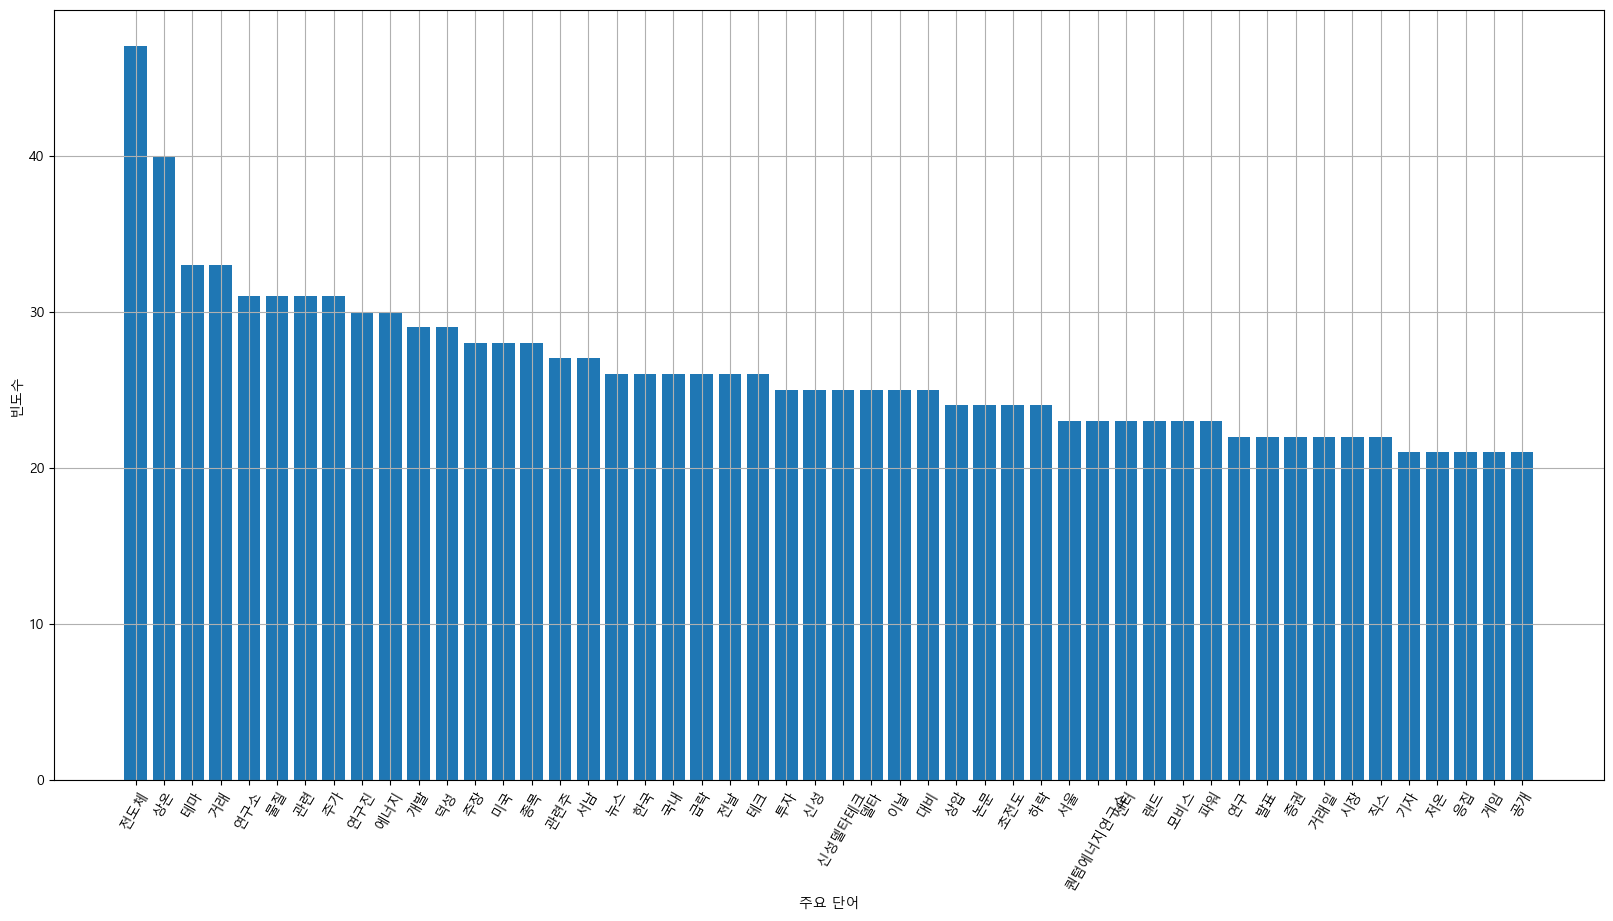

In [79]:
##  matplotlib를 이용하여 도표를 그릴 때 한글 폰트를 사용하는 방법
## matplotlib에서는 폰트는 rc config 설정을 통해 진행합니다. 이를 위해 먼저 폰트가 있는 경로를 알아야한다.

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager, rc   

font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)


plt.figure(figsize = (20,10))
plt.xlabel('주요 단어')
plt.ylabel('빈도수')
plt.grid(True)

Sorted_Dict_Values = sorted(wordInfo.values(), reverse=True)
Sorted_Dict_Keys = sorted(wordInfo, key=wordInfo.get, reverse=True)

plt.bar(range(len(wordInfo)), Sorted_Dict_Values, align='center')
plt.xticks(range(len(wordInfo)), list(Sorted_Dict_Keys), rotation=60)


# # 숫자 넣는 부분
# for rect in bar:
#     height = rect.get_height()
#     plt.text(rect.get_x() + rect.get_width()/2, height, '%d' % height, ha='center', va='bottom', size = 12)
# plt.grid()

plt.show()